In [1]:
import pandas as pd

In [13]:
df = pd.read_csv('results5/scorev.csv')

In [18]:
df.columns = ['label', 'imgdist', 'anomaly_score', 'zdist']

In [12]:
df.groupby('label').aggregate('mean')

,img_distance,anomaly_score,z_distance
label,,,
0,0.071663,0.106780,0.017217
1,0.067080,0.104986,0.016655


In [14]:
df_loss = pd.read_csv('results5/train_wgangp_log.csv')

In [15]:
df_loss

,Epoch,Batch,D loss,G loss
0,0,0,9.334910,-0.012427
1,0,5,9.107635,-0.012184
2,0,10,8.904884,-0.013921
3,0,15,8.495410,-0.014828
4,0,20,8.141689,-0.017377
...,...,...,...,...
10245,49,1000,-0.920672,5.555588
10246,49,1005,0.086685,7.961806
10247,49,1010,0.711292,6.447569
10248,49,1015,1.101614,6.049072


In [16]:
loss_agg = df_loss.groupby('Epoch').aggregate('mean')
loss_agg

,Batch,D loss,G loss
Epoch,,,
0,510.0,-0.191391,-1.603080
1,510.0,-0.429874,-0.678164
2,510.0,-0.646654,-0.176921
3,510.0,-0.254813,0.494336
4,510.0,-1.048358,1.216942
5,510.0,-0.720554,1.042089
6,510.0,-0.484638,1.474992
7,510.0,-0.424786,2.141771
8,510.0,-0.424930,2.773138


In [17]:
import matplotlib.pyplot as plt

In [18]:
df[df['label']==1].loc[:,'anomaly_score']

KeyError: 'label'

In [19]:
loss_agg.loc[:,"D loss"]

Epoch
0    -0.191391
1    -0.429874
2    -0.646654
3    -0.254813
4    -1.048358
5    -0.720554
6    -0.484638
7    -0.424786
8    -0.424930
9    -0.419634
10   -0.479719
11   -0.446900
12   -0.485604
13   -0.369902
14   -0.339972
15   -0.456692
16   -0.414130
17   -0.412729
18   -0.491288
19   -0.539059
20   -0.340603
21   -0.311667
22   -0.197875
23   -0.258818
24   -0.369309
25   -0.217287
26   -0.276535
27   -0.153550
28   -0.267706
29   -0.263461
30   -0.367708
31   -0.342015
32   -0.320063
33   -0.277079
34   -0.158601
35   -0.430241
36   -0.239022
37   -0.223441
38   -0.424492
39   -0.188697
40   -0.134197
41   -0.220738
42   -0.296637
43   -0.213422
44   -0.275391
45   -0.052527
46   -0.290696
47   -0.334311
48   -0.145511
49   -0.083307
Name: D loss, dtype: float64

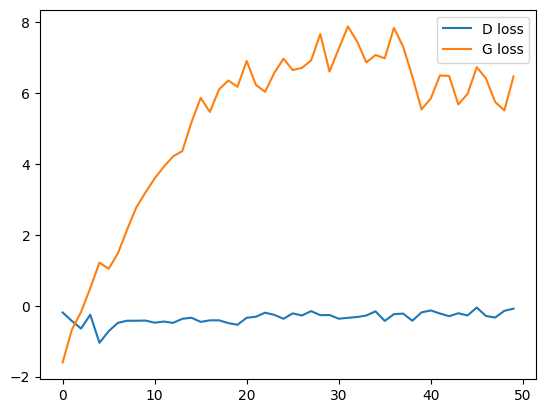

In [20]:
plt.plot(loss_agg['D loss'], label = 'D loss')
plt.plot(loss_agg['G loss'], label = 'G loss')
plt.legend()
plt.show()

In [13]:
df_loss2 = pd.read_csv('results/train_encoder_log.csv')

In [14]:
df_loss2.groupby('Epoch').aggregate('mean')

,Batch,E loss
Epoch,,
0,510.0,0.287415
1,510.0,0.242918
2,510.0,0.226957
3,510.0,0.218812
4,510.0,0.212744
5,510.0,0.209357
6,510.0,0.206672
7,510.0,0.204751
8,510.0,0.196090
